# 순환 신경망으로 IMDB 리뷰 분류하기
- IMDB는 대표적인 순환 신경망 문제
- 데이터셋을 두 가지 방법으로 변형하여 순환 신경망에 주입  
    1) 원-핫 인코딩  
    2) 단어 임베딩

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## IMDB 리뷰 데이터셋
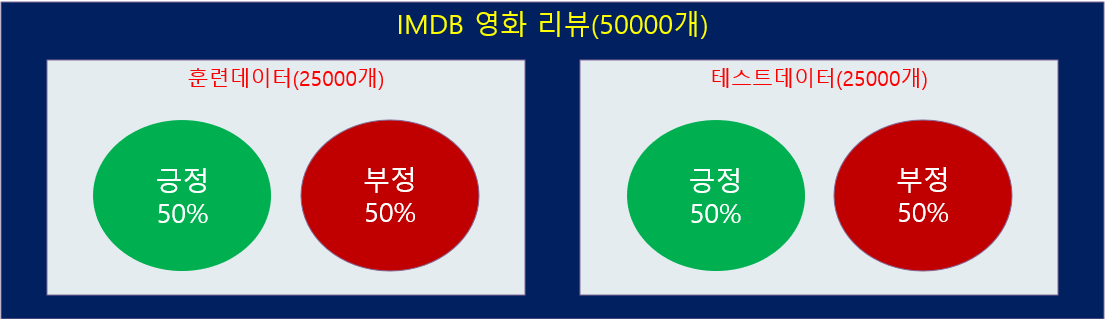
- 이 데이터셋은 영어 데이터로 IMDB 영화 사이트의 긍정리뷰 25000개와 부정리뷰 25000개가 포함되어 있음
- 2가지의 클래스로 분류(긍정/부정)
- 이러한 분류는 감성분류에 속함
- 리뷰는 텍스트 형태이므로 자연어 처리(NLP) 개념(음성인식, 기계번역 포함)
- 데이터셋은 말뭉치(corpus)라고도 불림(IMDB 영화 리뷰 데이터셋 역시 말뭉치)

## 자연어 처리 개념
- 텍스트 데이터 자체를 신경망에 전달하지는 않음
- 결국 컴퓨터에서 처리하는 모든 것은 숫자 데이터
- 합성곱 신경망에서 이미지 처리 시 변환하지 않은 것은 픽셀이라는 숫자로 처리했기 때문

### 텍스트 데이터를 숫자로 변경하는 방법
- 문자 단위로 처리하는 경우 문자인코딩 방식을 활용(ASCIICode, Unicode 등)
- 단어 단위로 처리하는 경우 단어마다 고유한 정수를 부여(정수값의 크기는 무의미)
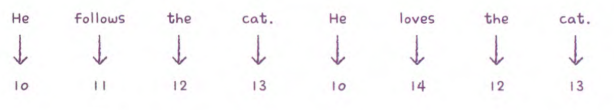
- 단어를 구분하기 위해 영어인 경우 소문자로 변환 후 특수문자들을 적절히 처리하고 공백 기준으로 나눔
- 나누어진 각 단어는 토큰(Token)이라고 지칭
- 하나의 샘플은 여러 개의 토큰으로 이루어져 있으며 1개의 토큰이 하나의 타임스텝에 해당됨
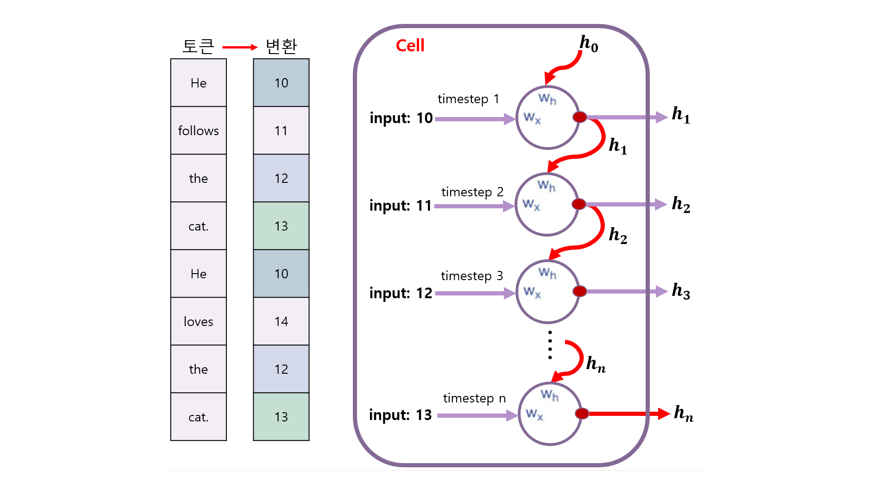

#### 데이터 가져오기
- IMDB 리뷰 데이터셋은 영어로 된 문장이며 텐서플로우는 문장을 정수로 변환한 데이터를 제공
- 리뷰 문자열을 분리 한 후 숫자로 변환하기(토큰 생성) 위해 사용하는 정수값이 있음(어휘 사전)
- 단어(토큰)를 숫자로 변환하기 위해 어휘사전에 있는 값이 이용됨
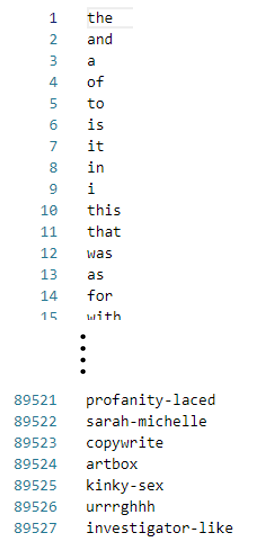
- num_words=500은 출현 빈도가 많은 단어 중 500개만 사용하겠다는 의미

In [2]:
from tensorflow.keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=500)

In [3]:
# 데이터 모양 확인
X_train.shape, X_test.shape

((25000,), (25000,))

##### 훈련 데이터가 1차원으로 보이는 이유
- 텍스트는 길이가 각각 다를 수 있으므로 고정 크기의 2차원 배열에 저장 불가
- 리뷰마다 별도의 파이썬 리스트([]) 형태로 리뷰가 저장되어 있음
- 즉 파이썬 리스트를 요소로 하는 넘파이 배열임

In [4]:
# 정답 데이터의 카테고리(클래스) 확인
len(set(y_train))

2

In [5]:
# 첫 번째 리뷰의 토큰 길이
print(len(X_train[0]))

218


In [6]:
# 두 번째 리뷰의 리뷰 토큰 길이
print(len(X_train[1]))

189


In [7]:
# 첫 번째 리뷰의 전체 토큰 값
print(X_train[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


##### 해석
- 첫 번째 1은 리뷰의 시작을 의미
- 어휘 사전에 500개의 데이터만 들어있으므로 사전에 없는 단어는 2로 표현됨
- 각 숫자는 어떤 단어에 매칭되는데 숫자의 크기가 단어의 좋고 나쁨에 영향을 주지 않음(단순 단어 식별을 위한 숫자)

In [8]:
# 정답 데이터 확인
print(y_train[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


#### 데이터 나누기 (훈련:8, 검증:2)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [10]:
X_train.shape, y_train.shape

((20000,), (20000,))

In [11]:
X_test_val.shape, y_test_val.shape

((5000,), (5000,))

In [12]:
# 파이썬의 list comprehansion(내포)을 이용하여 훈련 데이터의 각각 원소(파이썬 리스트) 길이를 확인
import numpy as np

lengths = np.array([len(x) for x in X_train])
lengths

array([259, 520, 290, ..., 300,  70,  77])

In [13]:
# 리뷰의 평균 길이와 중간값 확인
np.mean(lengths), np.median(lengths)

(239.00925, 178.0)

##### 결과
- 리뷰의 평균 길이가 중간값보다 많으므로 많은 문자를 가진 리뷰도 있는 것으로 보임
- 리뷰 길이 데이터는 한쪽으로 치우친 형태일 것으로 판단

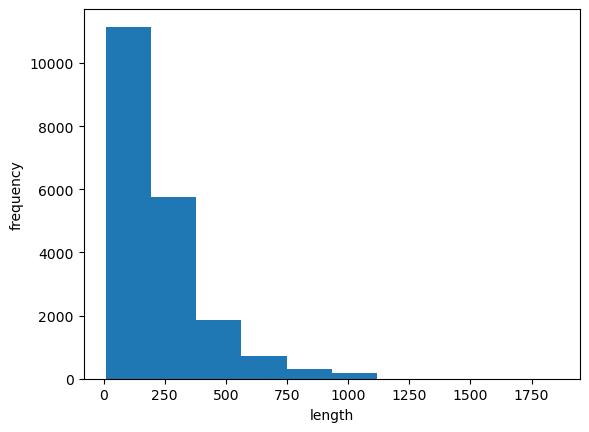

In [14]:
# 히스토그램으로 확인
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

##### 결과
- 대부분의 리뷰 길이는 300미만이지만 아주 큰 데이터(단어가 많은 리뷰)가 포함되어 평균이 중간값보다 높음

### 패딩
- 리뷰가 대부분 짧은 편이므로 이 예제에서는 중간값보다 짧은 100개의 단어만 사용하도록 함
- 수동으로 20000개의 리뷰를 100개의 단어로 맞추기는 어려움
- 100개보다 작은 리뷰의 길이를 100에 맞추기 위해 패딩을 적용(패딩은 보통 0으로 채움)해야 함
- 케라스는 시퀀스 데이터의 길이를 맞춰주는 pad_sequences()를 제공함

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_seq = pad_sequences(X_train, maxlen=100)

In [16]:
X_train_seq.shape

(20000, 100)

- 기존 훈련데이터는 파이썬 리스트의 배열이었는데 길이를 100으로 맞춘 X_train_seq는 2차원 배열이 됨
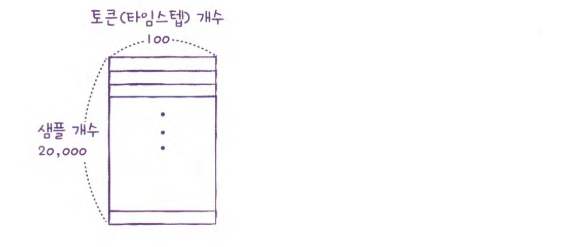

#### 첫 번째 샘플 출력

In [17]:
print(X_train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


- 앞뒤에 패딩 값인 0이 없으므로 100개 이상의 길이를 가진 문자열이었던 것으로 보임
- 원본 샘플의 끝을 확인하면 샘플의 어디(앞, 뒤)가 짤렸는지 확인할 수 있음

In [18]:
print(X_train[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


- 맨 뒤의 데이터와 일치하므로 앞부분(pre)이 짤린 것으로 확인됨
- pad_sequences()는 기본으로 maxlen보다 긴 시퀀스의 앞부분을 자름(truncating='post'로 지정하면 뒷부분을 자름)
- 현재 영화 리뷰는 마지막 소감이 중요할 것으로 판단하여 시퀀스의 앞부분을 자르도록 함
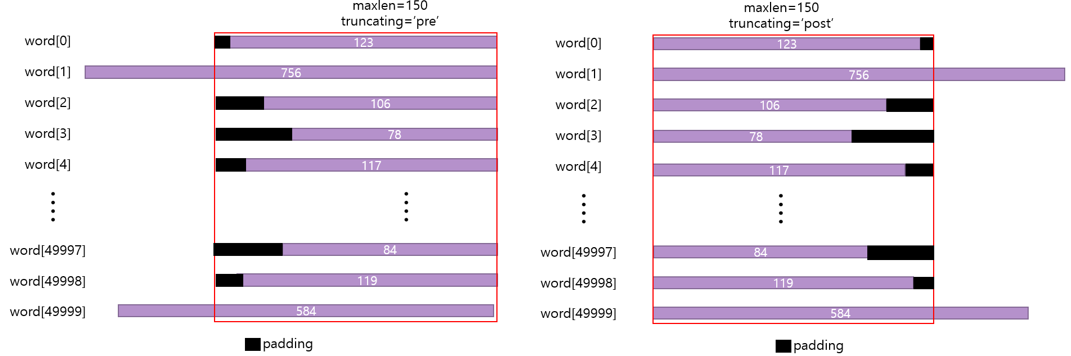

#### 다른 리뷰의 데이터 확인

In [19]:
print(X_train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


- 앞부분에 0이 연속으로 들어가 있으므로 100개보다 적은 샘플이었으며 앞의 0인 부분은 패딩이 적용된 것으로 보임

#### 검증 세트의 길이도 100으로 맞춤

In [20]:
X_test_val_seq = pad_sequences(X_test_val, maxlen=100)

## 순환 신경망 만들기
- 케라스는 여러 종류의 순환층 클래스를 제공
- 가장 간단한 SimpleRNN클래스 사용
- IMDB 리뷰 분류문제는 이진 분류이므로 마지막 출력층을 1개의 뉴런을 가지고 시그모이드 활성화 함수 적용하면 됨

### Sequential클래스로 만든 순환신경망 코드로 확인
- Sequential클래스는 층을 순서대로 쌓는 역할로 순차 데이터와는 관계없음
- 합성곱 신경망, 순환 신경망 등 일반적인 인공 신경망 모델을 모두 생성할 수 있는 클래스

In [21]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.Input(shape=(100, 500)))
model.add(keras.layers.SimpleRNN(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

#### SimpleRNN 적용
- SimpleRNN의 뉴런 개수를 8개로 설정(정해진 것이 아님)
- 첫 번째 매개변수는 뉴런에 사용할 데이터의 형태 input_shape에 입력 차원을 (100, 500)으로 지정
- 첫 번째 차원이 100인 것은 샘플의 길이를 100으로 지정했기 때문(100개의 단어를 입력으로 사용한다는 의미)
- 리뷰 데이터를 불러올 때 500개의 단어만 사용하도록 했으므로 고유한 단어는 모두 500개
- 훈련 데이터에 포함될 수 있는 정수값의 범위는 0~499
    - 토큰을 정수로 변환한 데이터 그대로 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만듦(결과 왜곡)
- 단순한 정수값을 크기 속성을 제거하고 신경망에 입력하기 위해 원-핫 인코딩을 적용
    - 원-핫 인코딩 시 필요한 토큰이 500개 이므로 input_shape에 지정하는 속성에 두 번째 차원을 500으로 설정
    - 토큰마다 500개의 숫자를 사용하여 표현(500개 중 1개만 1 나머지 0으로 만들어 크기 속성을 없애는 방식)

#### 훈련 데이터 원-핫 인코딩
- 리뷰의 토큰(단어)에 원-핫 인코딩을 진행
- 케라스에서 원-핫 인코딩을 위한 유틸을 제공(keras.utils 패키지의 to_categorical()적용)

In [22]:
X_train_oh = keras.utils.to_categorical(X_train_seq)

#### 원-핫 인코딩된 X_train_oh의 크기 확인
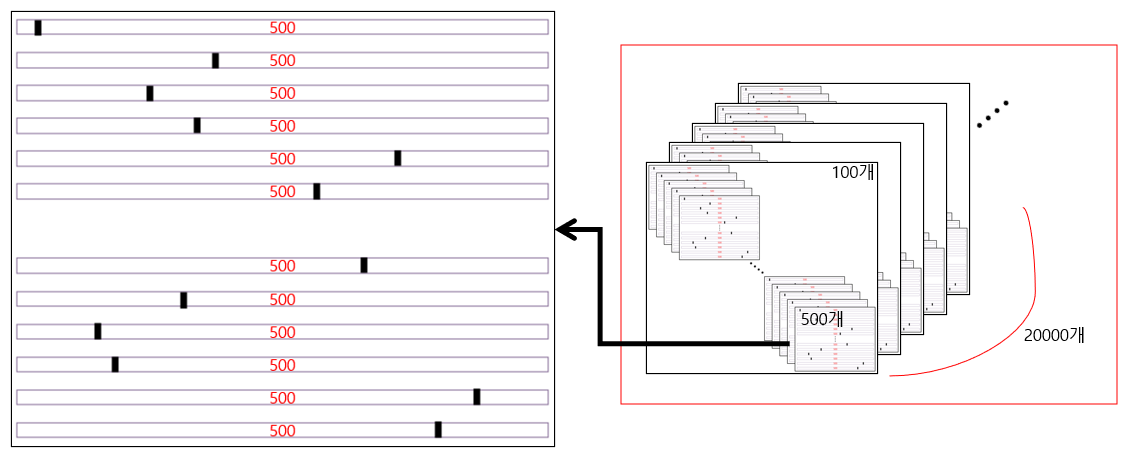

In [23]:
X_train_oh.shape

(20000, 100, 500)

In [24]:
len(X_train_oh[0])

100

In [25]:
X_train_oh[0].shape

(100, 500)

In [26]:
X_train_oh[0][0].shape

(500,)

#### 첫 번째 샘플(시퀀스)의 데이터 확인

In [27]:
print(X_train_seq[0][-100:-1])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470]


#### 첫 번째 샘플의 첫 번째 토큰 10값이 잘 인코딩 되었는지 확인

In [28]:
print(X_train_oh[0][0][:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

#### 첫 번째 샘플의 두 번째 토큰 4값이 잘 인코딩 되었는지 확인

In [29]:
print(X_train_oh[0][1][:20])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### 각 원-핫 인코딩 된 원소의 합을 출력해보면 1이 되는 것을 확인

In [30]:
np.sum(X_train_oh[0][0]), np.sum(X_train_oh[0][1])

(1.0, 1.0)

#### 검증 데이터셋 원-핫 인코딩
- 훈련 데이터셋과 동일하게 검증 데이터셋도 인코딩 필요

In [31]:
X_test_val_oh = keras.utils.to_categorical(X_test_val_seq)

#### 모델 요약 정보 출력하여 확인

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │           4,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,081 (15.94 KB)

 Trainable params: 4,081 (15.94 KB)

 Non-trainable params: 0 (0.00 B)

##### 해석
- SimpleRNN에 전달할 샘플의 크기는 (100, 500)이지만 이 순환층은 마지막 타임스텝의 은닉 상태만 출력함
    - 출력 크기가 순환층의 뉴런 개수와 같음(뉴런 8개, 출력 8개)
- 순환층에 사용된 모델 파라미터 개수 계산하기
    - 입력토큰: 500개(원-핫 인코딩된 배열)
    - 순환층 뉴런 개수(cell 개수): 8개
    - 500 x 8 = 4000개의 은닉상태(출력) (입력토큰 x 순환층 뉴런)
    - 이 순환층의 은닉상태는 다시 다음 타임스텝에 사용되어지며 이 때 또 다른 가중치와 곱해짐
        - 8 x 8 = 64개의 가중치 필요
    - 절편: 8개 (뉴런마다 하나의 절편이 존재)
    - 총 모델 파라미터 개수: 4000 + 64 + 8 = 4072 
- 케라스의 API를 이용하여 순환 신경망 모델을 생성함

## 순환 신경망 훈련하기
- 케라스 API는 훈련하는 방식이 다른 신경망과 동일(케라스 API의 장점)
- RMSprop의 기본 학습률 0.001을 변경하여 적용해보기 위해 별도로 RMSprop객체를 생성함(반드시 이렇게 해야되는 것이 아님)
- 에포크 횟수는 100으로 늘리고 배치 크기를 64개로 설정
- 그 외의 체크포인트나 조기 종료 등을 구성하는 코드는 거의 동일

In [33]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4) # 학습률은 10의 -4승으로 설정함(정해진 것은 아님)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(X_train_oh, y_train, epochs=100, batch_size=64,
                    validation_data=(X_test_val_oh, y_test_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 186ms/step - accuracy: 0.4938 - loss: 0.7051 - val_accuracy: 0.5002 - val_loss: 0.7008
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.5025 - loss: 0.6988 - val_accuracy: 0.5012 - val_loss: 0.6976
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.5135 - loss: 0.6950 - val_accuracy: 0.5068 - val_loss: 0.6950
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5237 - loss: 0.6921 - val_accuracy: 0.5158 - val_loss: 0.6929
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.5343 - loss: 0.6896 - val_accuracy: 0.5278 - val_loss: 0.6910
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5440 - loss: 0.6873 - val_accuracy: 0.5400 - val_loss: 0.6895
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.5574 - loss: 0.6852 - val_accuracy: 0.5408 - val_loss: 0.6881
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5662 - loss: 

##### 결과
- 36번째 에포크에서 종료됨(다시 실행 시 달라질 수 있음)
- 검증세트에 대한 정확도는 약 80%정도의 정확도를 보여줌

#### 그래프로 확인
- 훈련 손실과 검증 손실을 그래프로 출력하여 훈련과정에서 변화 확인

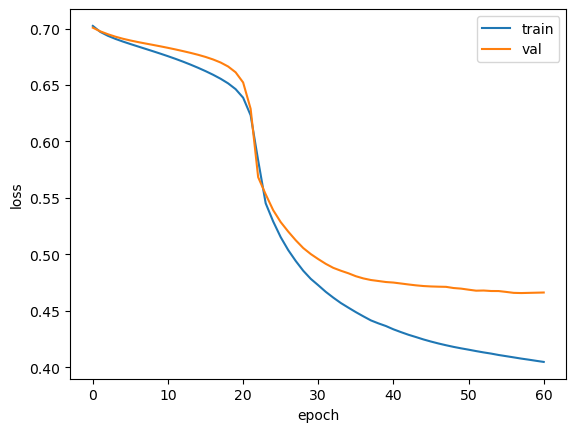

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 해석
- 훈련 손실은 꾸준히 감소
- 검증 손실은 감소폭이 줄어드는 시점이 있음(대략 20번째 에포크 전후로)
- 적절하게 훈련을 멈춘 것으로 볼 수 있음

## 단어 임베딩을 사용하기
- 앞에 예제에서는 리뷰 감성 분류를 위해 입력 데이터에 원-핫 인코딩을 적용함
- 입력 데이터가 커지는 것이 원-핫 인코딩의 단점
- 토큰 1개를 500개 차원으로 늘리는 것은 500배나 크게 만드는 것(반드시 좋다,나쁘다를 말할 수는 없음)
- 순환 신경망에서는 단어 임베딩을 많이 활용함

### 단어 임베딩이란
- 각 단어를 고정된 크기의 실수 벡터로 변경함
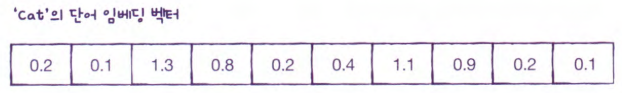
- 원-핫 인코딩으로 만든 값보다 의미 있는 값으로 만들어짐
- 자연어 처리에서 이 방식이 좋은 성능을 내는 경우가 많음
- 단어 임베딩 층을 생성하기 위한 클래스도 케라스에서 제공(keras.layers패키지에서 Embedding클래스)
- Embedding 클래스를 다른 층을 추가하는 것과 같이 모델에 추가하면 최초 모든 벡터가 랜덤으로 초기화됨
- 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습함

#### 장점
- 입력으로 정수 데이터를 받음(원-핫 인코딩 불필요)
- 임베딩은 (100,) 크기의 샘플을 (100, 20)과 같이 2차원 배열로 늘리지만 원-핫 인코딩에 비해 훨씬 작은 크기로 단어를 잘 표현함

#### 단어 임베딩을 적용하기 위해 두 번째 신경망 생성

In [37]:
model2 = keras.Sequential()

model2.add(keras.Input(shape=(100,)))
model2.add(keras.layers.Embedding(500, 16))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

##### 해석
- Embedding생성 시 첫 번째 매개변수는 어휘 사전의 크기
- 예제에서 500개의 단어만 사용하기로 했으므로 매개변수 값을 500으로 설정
- 두 번째 매개변수는 임베딩 벡터의 크기
    - 원-핫 인코딩보다 더 작은 크기의 16벡터 적용
- 세 번째 매개변수는 입력 시퀀스의 길이
    - 샘플의 길이를 100으로 맞추어서 훈련 시퀀스를 생성했으므로 100으로 설정
- SimpleRNN층과 Dense층과의 차이

#### 만들어진 신경망 모델의 정보 확인

In [38]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,209 (32.07 KB)

 Trainable params: 8,209 (32.07 KB)

 Non-trainable params: 0 (0.00 B)

##### 해석
- 이 모델은(100, )크기의 입력을 받아(100, 16)크기의 출력을 생성
- 모델 파라미터 개수 계산
    - Embedding클래스는 500개의 각 토큰을 크기가 16인 벡터로 변경
        - 500 x 16 = 8000개의 모델 파라미터를 가짐
    - SimpleRNN 층은 임베딩 벡터 크기가 16이므로 8개의 뉴런과 곱하기 위해 필요한 가중치를 가짐
        - 16 x 8 = 128개를 가짐
    - 은닉상태에 곱해지는 가중치
        - 8 x 8 = 64개
    - 마지막으로 8개의 절편
    - 전체 모델 파라미터 개수
        - 128 + 64 + 8 = 200
    - 마지막 Dense층은 이전과 동일하게 9개
- 원-핫 인코딩보다 SimpleRNN에 주입되는 입력의 크기가 줄었으나 임베딩 벡터는 단어를 잘 표현하므로 결과가 좋을 것으로 예상

#### 임베딩이 적용된 모델로 훈련 진행

In [39]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(X_train_seq, y_train, epochs=100, batch_size=64,
                     validation_data=(X_test_val_seq, y_test_val),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.5177 - loss: 0.6920 - val_accuracy: 0.6000 - val_loss: 0.6779
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6057 - loss: 0.6746 - val_accuracy: 0.6494 - val_loss: 0.6626
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6594 - loss: 0.6571 - val_accuracy: 0.6810 - val_loss: 0.6474
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.6921 - loss: 0.6370 - val_accuracy: 0.7106 - val_loss: 0.6253
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7167 - loss: 0.6168 - val_accuracy: 0.7188 - val_loss: 0.6112
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7381 - loss: 0.5952 - val_accuracy: 0.7244 - val_loss: 0.5963
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7507 - loss: 0.5755 - val_accuracy: 0.7480 - val_loss: 0.5733
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7632 - loss: 0

##### 결과
- 원-핫 인코딩을 사용한 모델과 비슷한 성능을 보임
- 순환층의 가중치 개수는 훨씬 작고 훈련 세트의 크기도 많이 줄였음

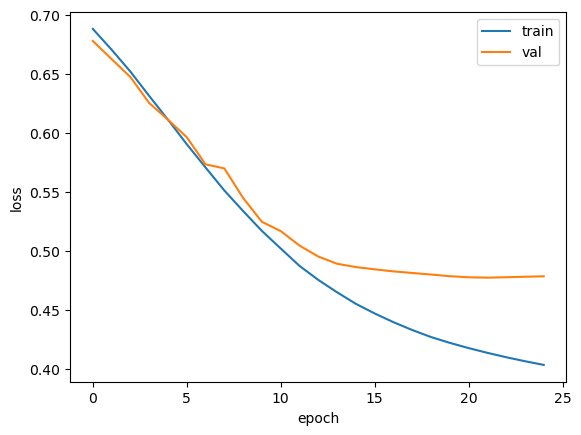

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

##### 결과
- 검증 손실이 더 감소되지 않아서 훈련이 적절하게 조기종료가 된 것으로 보임
- 훈련 손실은 계속 감소함